(example-quantum)=
# Quantum simulation

In this tutorial, we will learn how to use simphony's quantum simulator to simulate photonic circuits. 

## Background

Let us first discuss some foundational quantum optics that will be useful for using and understanding simphony's quantum simulator. Let us consider a bosonic system with mode operators $\hat{a}_k$ and $\hat{a}_k^{\dagger}$ where $k=1,...,n$ that satisfy the commutation relation $[\hat{a}_k, \hat{a}_l^{\dagger}] = \delta_{kl}$. The quadrature operators $\hat{x}$ and $\hat{p}$ are defined for the $k$-th mode as follows:

$$\hat{x}_k = \frac{1}{2}(\hat{a}_k + \hat{a}_k^{\dagger})$$

$$\hat{p}_k = \frac{1}{2i}(\hat{a}_k - \hat{a}_k^{\dagger})$$

Simphony is capable of simulating a specific class of quantum states on photonic circuits, namely those whose phase space distributions can be mathematically represented in the Gaussian form. These states, called Gaussian states, are represented by a vector of means, $r$, and a covariance matrix, $\sigma$. These can be defined using the quadrature operators as follows:

$$r = \langle \hat{r} \rangle = \begin{pmatrix} \langle \hat{x}_1 \rangle \\ \langle \hat{p}_1 \rangle \\ \vdots \\ \langle \hat{x}_n \rangle \\ \langle \hat{p}_n \rangle \end{pmatrix}$$

$$\sigma_{jk} = \frac{1}{2} \langle \{ \hat{r}_j, \hat{r}_k \} \rangle - \langle \hat{r}_j \rangle \langle \hat{r}_k \rangle$$

Some examples of Gaussian states that can be fully described using this form are coherent states, squeezed states, and thermal states.

Lets look at an example of a coherent state which is the type of state that is produced by a laser. A coherent state is usually denoted by the complex field amplitude $|\alpha\rangle$ and is defined in the Fock basis (photon number basis) as:

$$|\alpha\rangle = e^{-\frac{|\alpha|^2}{2}} \sum_{n=0}^{\infty} \frac{\alpha^n}{\sqrt{n!}} |n\rangle$$

where $|n\rangle$ is the $n$-th Fock state. This state can be more simply defined in the gaussian form with a means vector of $(\Re(\alpha), \Im(\alpha))$ and a covariance matrix of $\frac{1}{4}\mathbb{I}$.

Lets define a coherent state with a complex field amplitude of $\alpha = 1 + i$ and plot its phase space distribution.

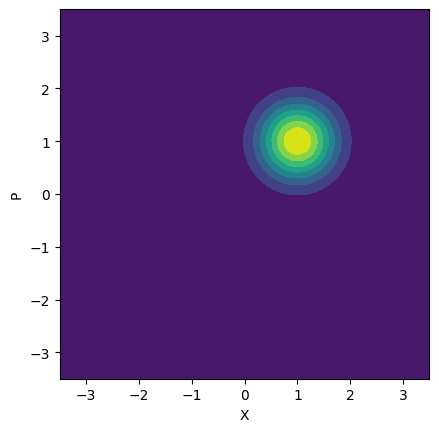

Convention: xpxp
Means: [1. 1.]
Cov: 
[[0.25 0.  ]
 [0.   0.25]]


In [1]:
from simphony.quantum import CoherentState
import matplotlib.pyplot as plt

# Create a coherent state with alpha = 1+1j

# port="in" is the name of the circuit port you inject the state in this case,
# we haven't defined any circuit yet, so we'll use an arbitrary port name "in"
coherent_state = CoherentState(port="in", alpha=1+1j) 
coherent_state.plot_mode(0) # we only have one mode in this state
plt.show()
print(coherent_state)

Coherent states are probably the simplest type of Gaussian states. Other Gaussian states can be defined by applying linear transformations to coherent states. For example, a squeezed state is defined by applying a squeezing operator to a coherent state. A squeezing operator is defined as:

Simphony can also represent states that have more than one mode. Lets see how we can define a 

```{note} 

Simphony adopts the convention of $\hbar=1/2$ such that $[\hat{x}, \hat{p}] = i\hbar = i/4$ where $\hat{x}$ is the position operator, $\hat{p}$ is the momentum operator, and $\hbar$ is the reduced Planck constant. Which corresponds to the uncertainty of the vacuum state $\langle (\Delta \hat{X})^2\rangle=\frac{1}{4}$ This convention is used in the definition of the covariance matrix and used in {cite:p}`brask2021gaussian`.
```

## Simulation

Simphony takes the classical s-parameters of a circuit and then converts them into a quantum compatible form. One requirement of any quantum system is any transformation must be unitary. This means that it must not have any loss. Simphony converts the s-parameters into a unitary matrix by adding extra modes for vacuum states to account for the loss. Simphony assumes that any loss in a circuit is uniform across all ports. 

In [1]:
import sax

from simphony.libraries import siepic

mzi, info = sax.circuit(
    netlist={
        "instances": {
            "gc_in": "gc",
            "splitter": "ybranch",
            "long_wg": "waveguide",
            "short_wg": "waveguide",
            "combiner": "ybranch",
            "gc_out": "gc",
        },
        "connections": {
            "gc_in,o0": "splitter,port 1",
            "splitter,port 2": "long_wg,o0",
            "splitter,port 3": "short_wg,o0",
            "long_wg,o1": "combiner,port 2",
            "short_wg,o1": "combiner,port 3",
            "combiner,port 1": "gc_out,o0",
        },
        "ports": {
            "in": "gc_in,o1",
            "out": "gc_out,o1",
        },
    },
    models={
        "ybranch": siepic.y_branch,
        "waveguide": siepic.waveguide,
        "gc": siepic.grating_coupler,
    }
)

In [4]:
from simphony.quantum import QuantumSim, CoherentState

wl = 1.55 # um
sim = QuantumSim(ckt=mzi, wl=wl, long_wg={"length": 150.0}, short_wg={"length": 50.0})
qstate = CoherentState(port="in", alpha=1+1j)
sim.add_qstate(qstate=qstate)
res = sim.run()

In [6]:
res

QuantumResult(s_params=Array([[[0.09961867-0.02142212j, 0.3800803 +0.15859034j],
        [0.3800803 +0.15859034j, 0.09961867-0.02142212j]]],      dtype=complex128), input_means=Array([1., 0., 0., 0., 1., 0., 0., 0.], dtype=float64), input_cov=Array([[0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25]], dtype=float64), transforms=Array([[[ 9.96186721e-02,  3.80080300e-01, -9.05541431e-01,
          0.00000000e+00,  2.14221209e-02, -1.58590337e-01,
         -1.68024456e-18, -0.00000000e+00],
        [ 3.80080300e-01,  9.96186721e-02,  0.00000000e+00,
         -9.05541431e-01, -1.58590337e-01,  2.142

**References**

```{bibliography}
:filter: docname in docnames
:style: unsrt
```